# Training functions

In [3]:
%matplotlib inline

import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import os
import time
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from google.colab import output
from scipy.io import savemat
import scipy.io
output.enable_custom_widget_manager()

class aux_bot():

    def __init__(self,drive_path = None, pos_path = None, motor_path = None,
                 train_forward = False, train_inverse = False,
                 normalize=True):

        # Setup device
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print("Connected: ", self.device)
        self.pos_path = pos_path
        self.motor_path = motor_path
        self.drive_path = drive_path
        self.model_path = None
        self.normalize = normalize

        # Parameter indicies
        self.m_inputs = 9
        self.n_outputs = 7
        self.motor_slice = slice(0,self.m_inputs)
        self.end_slice = slice(self.m_inputs,self.m_inputs+self.n_outputs)
        self.end_slice_xyz = slice(self.m_inputs,self.m_inputs+3)
        self.end_slice_q = slice(self.m_inputs+3,self.m_inputs+7)
        self.input_size = self.motor_slice.stop - self.motor_slice.start
        self.output_size = self.end_slice.stop - self.end_slice.start

        # Constant for forward model
        self.BATCH_SIZE = 16
        self.EPOCHS = 100
        self.LEARNING_RATE = 0.0005
        self.MOMENTUM = 0.9
        self.WEIGHT_DECAY = 0
        self.DROPOUT = 0
        self.LAYERS = 1
        self.GAMMA = 0.9

        # Upload data as fixed length trajectories instead of single points
        self.MAX_SEQ_LENGTH = 1
        self.upload_data()

        # Train forward model
        if  train_forward:
            self.fk_net = self.forward_net(hidden=1024,inputs=self.input_size,outputs=self.output_size)

            self.fk_net.load_state_dict(torch.load(drive_path + '/models/DNN_forward_2024_02_02-18_25_58_5.155mm'))

            self.train_forward(self.fk_net,self.EPOCHS,self.LEARNING_RATE,self.MOMENTUM,self.WEIGHT_DECAY,annealing=True)
            self.eval_model_forward(self.fk_net,self.fk_train_loss)

        # Load forward model instead
        if not train_forward:
            self.fk_net = self.forward_net(hidden=1024)
            self.fk_net.load_state_dict(torch.load(drive_path + '/models/DNN_forward_2024_02_02-18_25_58_5.155mm'), map_location=torch.device(self.device))
            self.fk_net.eval()
            print("[aux_net] Forward model succesfully loaded")

        # Constant for inverse model
        self.EPOCHS = 50
        self.LEARNING_RATE = 0.001
        self.MOMENTUM = 0.9
        self.DROPOUT = 0
        self.LAYERS = 1
        self.GAMMA = 0.95

        # Train inverse model
        if  train_inverse:
            self.ik_net = self.inverse_net(hidden=1600,inputs=self.output_size,outputs=self.input_size)
            self.train_inverse(self.ik_net,self.EPOCHS,self.LEARNING_RATE,self.MOMENTUM,self.WEIGHT_DECAY,annealing=True)
            self.eval_model_inverse(self.ik_net,self.ik_train_loss)

        # # Load forward model instead
        # if not train_inverse:
        #     self.inverse_model = self.inverse_net(hidden=1600)
        #     self.inverse_model.load_state_dict(torch.load(drive_path + '/models/inverse_2023_07_26-18_22_29_6.124pwm'))
        #     self.inverse_model.eval()
        #     self.inverse_model.to(self.device)
        #     print("[aux_net] Inverse model succesfully loaded")

    ############################
    # DATA PRE-PROCESSING
    ############################
    def normalize_data(self,data,d_type="full"):
        if d_type == "full":
            data = (data-self.min_scale)/(self.max_scale-self.min_scale)
        elif d_type == "motor":
                data = (data-self.min_scale[self.motor_slice])/(self.max_scale[self.motor_slice]-self.min_scale[self.motor_slice])
        elif d_type == "end_full":
            data = (data-self.min_scale[self.end_slice])/(self.max_scale[self.end_slice]-self.min_scale[self.end_slice])
        return data

    # Return data to original units
    def denormalize_data(self, data, d_type="full"):
        if isinstance(data, np.ndarray):
            if d_type == "full":
                data = data*(self.max_scale-self.min_scale)+self.min_scale
            elif d_type == "motor":
                    data = data*(self.max_scale[self.motor_slice]-self.min_scale[self.motor_slice])+self.min_scale[self.motor_slice]
            elif d_type == "end_full":
                data = data*(self.max_scale[self.end_slice]-self.min_scale[self.end_slice])+self.min_scale[self.end_slice]
            return data

        elif isinstance(data, torch.Tensor):
            if d_type == "full":
                data = data*(self.max_scale_torch-self.min_scale_torch)+self.min_scale_torch
            elif d_type == "motor":
                    data = data*(self.max_scale_torch[self.motor_slice]-self.min_scale_torch[self.motor_slice])+self.min_scale_torch[self.motor_slice]
            elif d_type == "end_full":
                data = data*(self.max_scale_torch[self.end_slice]-self.min_scale_torch[self.end_slice])+self.min_scale_torch[self.end_slice]
            return data

    class SequenceDataset(Dataset):
        def __init__(self, data_array, input_range, output_range, sequence_length=5,
                     shuffle=True, train=False, test=False, split=0.8,inverse=False):
            self.shuffle = shuffle
            self.sequence_length = sequence_length
            self.train = train
            self.test = test
            self.split = split
            if not inverse:
                self.y = torch.tensor(data_array[:, output_range]).float()
                self.X = torch.tensor(data_array[:, input_range]).float()
            else:
                self.y = torch.tensor(data_array[:, input_range]).float()
                self.X = torch.tensor(data_array[:, output_range]).float()
            self.N = self.X.shape[0]

            # Data shuffling
            if shuffle == True:
                torch.manual_seed(7)
                self.idx = torch.randperm(self.N)

            # Handle train-test split
            if self.train:
                self.N = int(self.N*self.split)
                if self.shuffle: self.idx = self.idx[0:self.N]
            if self.test:
                self.N = int(self.N*(1-self.split))
                if self.shuffle: self.idx = self.idx[-self.N:]

        def __len__(self):
            return self.N

        def __getitem__(self, i):
            assert 0 <= i < self.N, "Index out of bounds for sequence"

            if self.shuffle: i = self.idx[i]

            # Calculate the start index of the block
            block_num = i // self.sequence_length
            start_idx = block_num * self.sequence_length
            end_idx = i

            x = self.X[start_idx : end_idx + 1,:]
            x_len = end_idx - start_idx + 1

            # If x is shorter than the sequence length, pad with zeros along that dimension
            if x_len < self.sequence_length:
                # Calculate the number of rows to pad
                padding_size = self.sequence_length - x_len

                # Create a zero tensor for padding with the same number of columns as x
                padding = torch.zeros((padding_size, x.shape[1]), dtype=x.dtype)-1

                # Pad x at the beginning with the padding tensor
                x = torch.cat((x,padding), dim=0)

            return x, self.y[i]

        def get_all_items(self):
            Xs, Ys = [], []
            for i in range(self.N):
                x, y = self.__getitem__(i)
                Xs.append(x)
                Ys.append(y)
            return torch.stack(Xs), torch.stack(Ys)

    # Uploads training data
    def upload_data(self):
        # Position data
        self.pos_data = np.loadtxt(self.drive_path + self.pos_path, skiprows = 1, delimiter=',', dtype = 'float32',
                               usecols = tuple(range(3, 3 + self.output_size)))

        # Motor data
        motor_data = scipy.io.loadmat(self.drive_path+self.motor_path)
        self.motor_data = motor_data['points']
        data_len = np.shape(self.pos_data)[0]
        self.motor_data = self.motor_data[0:data_len, :]

        print(np.shape(self.pos_data))
        print(np.shape(self.motor_data))

        # Combine arrays into one
        self.data = np.hstack((self.motor_data,self.pos_data))

        self.data[:,self.end_slice_xyz] *= 10e2
        self.data_raw = np.copy(self.data)

        print("Inputs: ", self.data[0:3,self.motor_slice,])
        print("Outputs: ", self.data[0:3,self.end_slice,])

        self.min_scale = np.amin(self.data,0)
        self.min_scale[self.end_slice_q] = np.array([0,0,0,0])
        self.max_scale = np.amax(self.data,0)
        self.max_scale[self.end_slice_q] = np.array([1,1,1,1])

        self.min_scale_torch = torch.from_numpy(self.min_scale).to(self.device)
        self.max_scale_torch = torch.from_numpy(self.max_scale).to(self.device)

        if self.normalize:
            self.data = self.normalize_data(self.data)
            print("Norm inputs: ", self.data[0:3,self.motor_slice,])
            print("Norm outputs: ", self.data[0:3,self.end_slice,])


        self.test_sequence =   self.SequenceDataset(self.data,
                                                        input_range = self.motor_slice,
                                                        output_range = self.end_slice,
                                                        sequence_length = self.MAX_SEQ_LENGTH,
                                                        shuffle = True,
                                                        train = True,
                                                        inverse = False)

        # FORWARD train sequences
        self.forward_train_data = self.SequenceDataset(self.data,
                                                        input_range = self.motor_slice,
                                                        output_range = self.end_slice,
                                                        sequence_length = self.MAX_SEQ_LENGTH,
                                                        shuffle = True,
                                                        train = True,
                                                        inverse = False)

        # FORWARD test sequences
        self.forward_test_data = self.SequenceDataset(self.data,
                                                        input_range = self.motor_slice,
                                                        output_range = self.end_slice,
                                                        sequence_length = self.MAX_SEQ_LENGTH,
                                                        shuffle = True,
                                                        test = True,
                                                        inverse = False)

        # Set up FORWARD data loader
        self.forward_train_loader = torch.utils.data.DataLoader(self.forward_train_data, batch_size = self.BATCH_SIZE)
        self.forward_test_loader = torch.utils.data.DataLoader(self.forward_test_data, batch_size = self.BATCH_SIZE)

        # INVERSE train sequences
        self.inverse_train_data = self.SequenceDataset(self.data,
                                                        input_range = self.motor_slice,
                                                        output_range = self.end_slice,
                                                        sequence_length = self.MAX_SEQ_LENGTH,
                                                        shuffle = True,
                                                        train = True,
                                                        inverse = True)
        # INVERSE test sequences
        self.inverse_test_data = self.SequenceDataset(self.data,
                                                        input_range = self.motor_slice,
                                                        output_range = self.end_slice,
                                                        sequence_length = self.MAX_SEQ_LENGTH,
                                                        shuffle = True,
                                                        test = True,
                                                        inverse = True)

        # Set up INVERSE data loader
        self.inverse_train_loader = torch.utils.data.DataLoader(self.inverse_train_data, batch_size=self.BATCH_SIZE)
        self.inverse_test_loader = torch.utils.data.DataLoader(self.inverse_test_data, batch_size=self.BATCH_SIZE)


    ########################
    # FORWARD NETWORK
    ########################

    class forward_net(nn.Module):
        def __init__(self, inputs=9, hidden=1024, outputs=7):
            super().__init__()
            self.fc1 = nn.Linear(inputs,hidden)
            self.fc2 = nn.Linear(hidden,hidden)
            self.fc3 = nn.Linear(hidden,outputs)
            self.input_size = inputs
            self.output_size = outputs

        def forward(self,x):
            x = torch.flatten(x, 1)
            x = self.fc1(x)
            x = F.relu(x)
            x = self.fc2(x)
            x = F.relu(x)
            x = self.fc3(x)
            return x

    # Training function
    def train_forward(self,fk_net,epochs=10, lr=0.01, momentum=0.9, decay=0.0, verbose=1,annealing=True):
        fk_net.to(self.device)
        losses = []
        criterion = nn.MSELoss()
        self.optimizer = optim.Adam(fk_net.parameters(), lr, weight_decay=decay)

        # Aneal learning rate
        if annealing:
            scheduler = optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=self.GAMMA)

        for epoch in range(epochs):
            sum_loss = 0
            loss_list = []
            i = 0
            for X, y in self.forward_train_loader:
                X, y = X.to(self.device), y.to(self.device)

                # Reset gradients
                self.optimizer.zero_grad()

                # Run network forward, backward, and then update
                y_pred = fk_net(X)

                loss = criterion(y_pred,y)
                loss.backward()
                self.optimizer.step()

                # Track performance
                loss_list.append(loss.item())
                sum_loss += loss.item()

                if i % 100 == 99:
                    if verbose:
                        print('(Epoch {}, Iter {}) loss: {:.6f}'.format(epoch + 1, i + 1, sum_loss / 100))
                    sum_loss = 0
                i+=1
            if annealing:
                scheduler.step()
            losses.append(np.mean(loss_list))
            loss_list = []
        self.fk_train_loss = losses


    def quaternion_angular_error(self, q1, q2):
        # Determine if input is numpy or torch
        if isinstance(q1, np.ndarray):
            # For NumPy arrays

            # Normalize q2 for numpy
            norm_q1 = np.linalg.norm(q1, axis=1, keepdims=True)
            q1_normalized = q1 / norm_q1

            dot_product = np.sum(q1_normalized * q2, axis=1)

            # dot_product = np.clip(dot_product, -1.0, 1.0)
            absolute_dot_product = np.abs(dot_product)
            half_angle = np.arccos(absolute_dot_product)

        elif isinstance(q1, torch.Tensor):
            # For PyTorch tensors

            # Normalize q2 for torch
            norm_q1 = torch.norm(q1, dim=1, keepdim=True)
            q1_normalized = q1 / norm_q1

            dot_product = (q1_normalized * q2).sum(dim=1).clamp(-1.0, 1.0)
            absolute_dot_product = torch.abs(dot_product)
            half_angle = torch.acos(absolute_dot_product)
        else:
            raise TypeError("Unsupported input type. Expected numpy array or torch tensor.")

        # Double to get full angle, return in degrees
        return 2 * half_angle * (180.0 / np.pi)


    # Determine model error for predicting end effector pose
    def test_forward(self,fk_net,data='train'):
        accuracy = []
        err = np.array([])
        q_err = np.array([])

        # Create data loader
        if data == 'train': loader = self.forward_train_loader
        if data == 'test': loader = self.forward_test_loader

        # Run through the data
        for X, y in loader:
            X, y = X.to(self.device), y.to(self.device)

            y_pred = fk_net(X)

            # Convert back to CPU side
            y_pred = y_pred.numpy(force=True)
            y = y.numpy(force=True)

            if self.normalize:
                y_pred = self.denormalize_data(y_pred,"end_full")
                y = self.denormalize_data(y,"end_full")

            # Calculate postional error
            e = y_pred[:,0:3]-y[:,0:3]
            error = np.linalg.norm(e,axis = 1).flatten()
            accuracy.append(np.mean(error))
            err = np.append(err,error)

            # Calculate orientation error
            q_e = self.quaternion_angular_error(y_pred[:, 3:], y[:, 3:])
            q_error = q_e.flatten()
            q_err = np.append(q_err,q_error)

        return np.mean(accuracy), err, q_err

    # Plots the test accuracy of the model
    def eval_model_forward(self,fk_net,loss):
        # Plot losses during training
        plt.close('all')
        f = plt.figure()
        f.set_size_inches(16,4)
        ax1 = f.add_subplot(1,3,1)
        ax2 = f.add_subplot(1,3,2)
        ax3 = f.add_subplot(1,3,3,projection='3d')

        # Plot training loss
        ax1.plot(np.log10(loss),linewidth = 2)
        ax1.set_xlabel("Epochs",fontsize = 14)
        ax1.set_ylabel("log10(Loss)",fontsize = 14)
        ax1.set_title("Train Loss (Forward)",fontsize = 16)
        ax1.grid()

        # Determine train and test accuracy
        test_accuracy,test_error, test_q_error = self.test_forward(fk_net,data='test')
        train_accuracy, train_error, train_q_error = self.test_forward(fk_net,data='train')

        print("Train accuracy {:.10f} mm Test accuracy: {:.10f} mm".format(train_accuracy,test_accuracy))

        # Show testing accuracy
        ax2.hist(test_error,20)
        ax2.set_xlabel("Error (mm)",fontsize = 14)
        ax2.set_ylabel("Count",fontsize = 14)
        ax2.set_title("Positional Error for Test Data",fontsize = 16)
        ax2.grid()

        # Create a colormap and a normalize function based on the errors' range
        colormap = cmap=plt.cm.jet
        xyz_quat = np.zeros((len(self.forward_test_data),7))

        for i in range(len(self.forward_test_data)):
            X,y = self.forward_test_data[i]
            y = y.numpy(force=True)
            y = self.denormalize_data(y,"end_full")
            xyz_quat[i,:] = y

        # Create scatter plot of distance errors
        p = ax3.scatter(xyz_quat[:,0], xyz_quat[:,2], xyz_quat[:,1], c = test_error, cmap=plt.cm.jet,vmin=0,vmax=0.65*np.max(test_error), alpha=0.2)
        ax3.view_init(45, 45)
        cb = f.colorbar(p)
        cb.set_label("Error (mm)")
        ax3.set_xlabel("xe",fontsize = 14)
        ax3.set_ylabel("ye",fontsize = 14)
        ax3.set_zlabel("ze",fontsize = 14)
        ax3.set_title("Aux-Net Forward Model Performance",fontsize = 16)
        ax3.grid()
        plt.tight_layout()
        plt.show()

        # Save model
        model_name = 'DNN_forward_' + time.strftime('%Y_%m_%d-%H_%M_%S_') + '{:.3f}mm'.format(test_accuracy)
        torch.save(fk_net.state_dict(),self.drive_path + '/models/' + model_name)

        savemat(self.drive_path + "/metrics/" + model_name,{'test_error' : test_error,
                                                                    'test_q_error' : test_q_error})

        return test_accuracy

    #########################
    ## INVERSE NETWORK
    #########################

    class inverse_net(nn.Module):
        def __init__(self, inputs=7, hidden=1024, outputs=5):
            super().__init__()
            self.fc1 = nn.Linear(inputs,hidden)
            self.fc2 = nn.Linear(hidden,hidden)
            self.fc3 = nn.Linear(hidden,outputs)
            self.input_size = inputs
            self.output_size = outputs

        def forward(self,y):
            y = torch.flatten(y, 1)
            y = self.fc1(y)
            y = F.relu(y)
            y = self.fc2(y)
            y = F.relu(y)
            y = self.fc3(y)
            return y


    # Training function
    def train_inverse(self,ik_net,epochs=10, lr=0.01, momentum=0.9, decay=0.0, verbose=1, annealing=True):
        ik_net.to(self.device)
        losses = []
        criterion = nn.MSELoss()
        self.optimizer = optim.Adam(ik_net.parameters(), lr, weight_decay=decay)

        # Anneal the learing rate over time
        if annealing:
            scheduler = optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.9)

        for epoch in range(epochs):
            sum_loss = 0
            loss_list = []
            i = 0
            for X, y in self.inverse_train_loader:
                X, y = X.to(self.device), y.to(self.device)

                # Reset gradients
                self.optimizer.zero_grad()

                # Run network forward, backward, and then update
                y_pred = ik_net(X)
                loss = criterion(y_pred,y)
                loss.backward()
                self.optimizer.step()

                # Track performance
                loss_list.append(loss.item())
                sum_loss += loss.item()
                if i % 100 == 99:
                    if verbose:
                        print('(Epoch {}, Iter {}) loss: {:.6f}'.format(epoch + 1, i + 1, sum_loss / 100))
                    sum_loss = 0
                i += 1
            if annealing:
                scheduler.step()
            losses.append(np.mean(loss_list))
            loss_list = []
        self.ik_train_loss = losses

    # Determine model error from predicting motor inputs
    def test_inverse(self,ik_net,data='train'):
        accuracy = []
        err = np.array([])
        dist = np.array([])

        # Create data loader
        if data == 'train': loader = self.inverse_train_loader
        if data == 'test': loader = self.inverse_test_loader

        # Run through the data
        for X, y in loader:
            X, y = X.to(self.device), y.to(self.device)

            # Run network forward, backward, and then update
            y_pred = ik_net(X)

            # Denormalize data to find error
            if self.normalize:
                y_pred = self.denormalize_data(y_pred.numpy(force=True),"motor")
                y = self.denormalize_data(y.numpy(force=True),"motor")
                X = self.denormalize_data(X.numpy(force=True),"end_full")

            # Calculate error
            e = y_pred-y
            error = np.linalg.norm(e,axis = 1).flatten()
            accuracy.append(np.mean(error))
            err = np.append(err,error)

            # Record distance of this trajectory
            X = X[:,:,:3]
            diffs = np.diff(X, axis=1)  # This will reduce the 2nd dimension by 1
            point_dist = np.linalg.norm(diffs, axis=-1)
            seq_dis = np.sum(point_dist, axis=1)
            dist = np.append(dist, seq_dis)

        return np.mean(accuracy), err, dist

    # Plots the test accuracy of the model
    def eval_model_inverse(self,ik_net,loss):
        # Plot losses during training
        f = plt.figure()
        f.set_size_inches(20,5)
        ax1 = f.add_subplot(1,3,1)
        ax2 = f.add_subplot(1,3,2)
        ax3 = f.add_subplot(1,3,3,projection='3d')

        # Plot training loss
        ax1.plot(np.log10(loss),linewidth = 2)
        ax1.set_xlabel("Epochs",fontsize = 14)
        ax1.set_ylabel("log10(Loss)",fontsize = 14)
        ax1.set_title("Train Loss (Inverse)",fontsize = 16)
        ax1.grid()

        # Determine train and test accuracy
        test_accuracy,test_error,test_dist = self.test_inverse(ik_net,data='test')
        train_accuracy, train_error,train_dist = self.test_inverse(ik_net,data='train')
        self.test_accuracy = test_accuracy

        print("Train accuracy {:.10f} mm Test accuracy: {:.10f} mm".format(train_accuracy,test_accuracy))

        # Show testing accuracy
        ax2.hist(test_error,int(np.sqrt(len(test_error))))
        ax2.set_xlabel("Error (mm)",fontsize = 14)
        ax2.set_ylabel("Count",fontsize = 14)
        ax2.set_title("Error for Test Data",fontsize = 16)
        ax2.set_xlim(0,25)
        ax2.grid()

        # Create a colormap and a normalize function based on the errors' range
        colormap = cmap=plt.cm.jet
        norm = Normalize(vmin=test_error.min(), vmax=0.6*test_error.max())

        for i in range(len(self.inverse_test_data)):
            X,y = self.inverse_test_data[i]
            X = X.numpy(force=True)
            X = self.denormalize_data(X,"end_full")
            color = colormap(norm(test_error[i]))
            plt.plot(X[:,0],X[:,2],X[:,1],marker='o', color=color, alpha=0.2)

        # Plot formatting
        ax3.view_init(45, 45)
        cb = f.colorbar(plt.cm.ScalarMappable(cmap=colormap, norm=norm), ax=ax3, shrink=0.6)
        cb.set_label("Error (mm)")
        ax3.set_xlabel("xe",fontsize = 14)
        ax3.set_ylabel("ye",fontsize = 14)
        ax3.set_zlabel("ze",fontsize = 14)
        ax3.set_title("Aux-Net Inverse Model Performance",fontsize = 16)
        ax3.grid()
        plt.tight_layout()
        plt.show()

        # Save model
        model_name = 'DNN_inverse_'+time.strftime('%Y_%m_%d-%H_%M_%S_') + '{:.3f}mm'.format(test_accuracy)
        torch.save(ik_net.state_dict(),self.drive_path +'/models/'+model_name)

        savemat(self.drive_path + "/metrics/" + model_name,{'test_error' : test_error})


        f = plt.figure()
        plt.scatter(train_dist,train_error)
        plt.scatter(test_dist,test_error)
        plt.legend(["test","train"])
        plt.xlabel("trajectory distance (mm)",fontsize = 14)
        plt.ylabel("inverse model error (mm)",fontsize = 14)
        plt.show()

        return test_accuracy

    # Train and validation for Bayesian optimization of model
    def train_validate(self, lr: float, hidden_lstm: float, hidden: float):

            hidden_lstm = int(hidden_lstm)
            hidden = int(hidden)

            self.optima_net = self.inverse_net(hidden=hidden,
                                    hidden_lstm = hidden_lstm,
                                    inputs=self.output_size,
                                    outputs=self.input_size,
                                    device=self.device,
                                    dropout=self.DROPOUT,
                                    num_layers=1)

            # Train and evaluate
            self.train_inverse(self.optima_net,self.EPOCHS,lr,self.MOMENTUM,self.WEIGHT_DECAY,annealing=True,verbose=0)
            validation,_,_ = self.test_inverse(self.optima_net,data="test")

            return -validation

    # Run inverse prediction
    def inverse_prediction(self,input_path=None,output_path=None):
        with torch.no_grad():
            # Find end effector position we want to predict for inverse verification
            if input_path == None:

                n_points = 7500

                prediction_data = self.inverse_test_data

                # Gather all sequence data
                X, y = prediction_data.get_all_items()
                Y_pred = self.ik_net(X.to(self.device))

                # Create numpy arrays
                Y_pred = Y_pred.cpu()
                Y_pred = self.denormalize_data(Y_pred.numpy(),"motor")
                y = self.denormalize_data(y.numpy(),"motor")

                print("Predicted: ", Y_pred[0:10,:])
                print("Measured: ", y[0:10,:])

                np.savetxt(self.drive_path+"/input_regression.csv",Y_pred,delimiter=",",header="dtm_13,dtm_24,de_13,de_24,dl",comments='')
                savemat(self.drive_path+"/input_regression.mat",{"output": Y_pred})

            # Generate motor trajectory
            else:
                traj = torch.from_numpy(np.loadtxt(input_path,skiprows = 1,delimiter=',',dtype = 'float32',usecols = tuple(range(0,7))))
                traj = self.normalize_data(traj,"end_full")

                x_pred = self.ik_net(traj.to(self.device))
                x_pred = x_pred.cpu()
                x_pred = self.denormalize_data(x_pred,"motor").numpy(force=True)

                np.savetxt(output_path,x_pred,delimiter=",",header="dtm_13,dtm_24,de_13,de_24,dl",comments='')
                print("Trajectory saved!")



# Launch and train

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
Connected:  cuda:0
(12498, 7)
(12498, 9)
Inputs:  [[  0.           0.           0.           0.           0.
    0.           0.           0.           0.        ]
 [ -2.85625713  -5.96907981  -2.7352241   -6.40647506   2.49327677
    1.49596606  -3.20026289  -1.55748479  -0.52943977]
 [ -5.71251426 -11.93815962  -5.4704482  -12.81295013   4.98655355
    2.99193213  -6.40052578  -3.11496957  -1.05887954]]
Outputs:  [[-2.08007004e+01 -6.05276413e+00  2.43549213e+02 -7.74288410e-03
   1.72547027e-02  8.28647800e-03  9.99786198e-01]
 [-2.34040078e+01 -1.15404427e+01  2.43758798e+02 -7.24774599e-03
   2.18652859e-02  8.21123179e-03  9.99700069e-01]
 [-2.81751901e+01 -1.11318091e+01  2.47604921e+02  3.42158694e-03
   1.82829108e-02  9.16800182e-03  9.99784529e-01]]
Norm inputs:  [[0.88579035 0.88667244 0.87092579 0.87723304 0.88848099 0.87261845
  0.87649407 0.8879552  0.872411

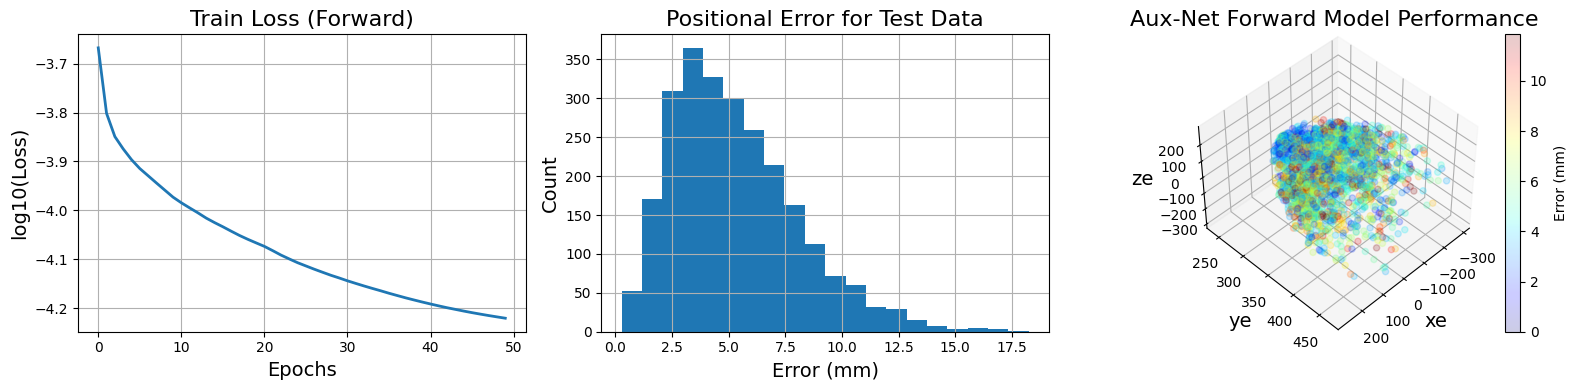

In [4]:
from google.colab import drive

drive.mount('/gdrive')
drive_path = '/gdrive/My Drive/Github/aux-net'

# Create bot and train
bot = aux_bot(drive_path = drive_path, pos_path = "/matlab/training/data/2024_02_03_14_22_02/positions_trim_new.csv", motor_path = "/matlab/training/data/2024_02_03_14_22_02/training_waypoints_matrix.mat",
              train_forward=True, train_inverse=False, normalize=True)

# Use inverse model for regression
# bot.inverse_prediction()
# bot.inverse_prediction(input_path = drive_path+'/experiments/trajectory_E1.csv', output_path = drive_path+'/experiments/motor_trajectory_E1.csv')

In [ ]:
print(bot.test_sequence[0])

(tensor([[0.5945, 0.8171, 0.7609, 0.6075, 0.9494, 0.9349, 0.7026, 0.8412, 0.8341]]), tensor([ 0.4994,  0.5113,  0.2267, -0.0211, -0.0797,  0.0143,  0.9965]))
